# MMMI Oversight Script


**TODO**: Consolidate initial setup to use same scripts as in interim. I.e., by having all agents 'attentive' to start.

**TODO**: track and display agent histories of consumption and earnings as well as dividend payouts.

**TODO**: Test for expected behavior with maximum attention rating (1)

**TODO**: `requirements.txt`

**TODO**: Begin automated tests

**TODO**: How do deal with varying 'AdjustPrbs' in quarterly and daily solution steps.

**TODO**: What are the macro population statistics, given our concept of macro agents including institutional investors, etc.

**TODO**: Fix steady state computation

**TODO**: Reduce NL logging/warning in the notebook.

In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
from HARK.Calibration.Income.IncomeTools import (
     sabelhaus_song_var_profile,
)
import hark_portfolio_agents as hpa

import logging
import math
from math import exp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

## Portfolio Consumption Model

Variable | Equation | Operation | Stage | Utility
-- | -- | -- | -- | --
\Risky | ~Dist | Shock | c | --
\TranShk | ~Dist | Shock | c | --
\PermShk | ~Dist | Shock | c | --
\Rport | \Rport = \PortShare * \Risky + (1 - \PortShare) * R | Update | c | --
b | b_{t} = a_{t-1} \RPort | Update | c | --
p | p_{t}=p_{t-1}\PermShk_{t} | Update | c | --
y | y_{t} = p_{t}\TranShk_{t} | Update | c | --
m | m_{t} = b_{t} + y_{t} | Update | c | --
c | c | Control | c | U(c)
a | a_{t} = m_{t} - c_{t} | Update | portshare | --
\PortShare | \PortShare | Control | portshare | 0


## Initialize the Simulation

### Initialize market information

Some initial values for the simulation.

$RAP_0$ is the starting risky asset price. This is adjust after every trading day.

HARK uses numerical values for wealth. This variable converts "HARK money" to dollars.

In [2]:
dollars_per_hark_money_unit = 1500

Expected rate of return and standard deviation of the market price process will be updated over time.

These are the starting values, derived from the S&P 500.

$\bar{r}_0 = 0.000628$

$sr_0 = 0.011988$

In [3]:
sp500_ror = 0.000628
sp500_std = 0.011988

market_rate_of_return = sp500_ror
market_standard_deviation = sp500_std

Quarterly dividend rate and standard deviation.

In [4]:
dividend_ror = 0.03
dividend_std = 0.01

Calendar variables. Will ultimately set to be realistic; for now set low for testing.

In [5]:
# Now set in Financial Model
days_per_quarter = 60 # Number of days in a quarter / An empirical value based on trading calendars.

# Simulation parameters
quarters_per_simulation = 3 # Number of quarters to run total

# Number of market runs to do per quarter
# Valid values: 1, 2, 3, 4, 5, 6, 10, 12, 15, 20, 30, 60...
runs_per_quarter = 2 

# For John's prefered condition: days per quarter = runs per quarter
# Best if an integer.
days_per_run = days_per_quarter / runs_per_quarter

An attention rate: the chance on any run that an agent will pay attention to the market and trade.

Later, this can be a more realistic function of agent circumstances.

In [6]:
attention_rate = 1 / runs_per_quarter ## upping this to make more agents engaged in trade

A times we will need to combine the quarterly rates from the price process (capital gains) and the dividends.


### Data stores

For prices, rates or return, and standard deviations over time.

In [7]:
history = {}

history['buy_sell'] = []
history['owned_shares'] = []
history['total_assets'] = []

### Calculating risky expectations



In [8]:
fm = hpa.FinanceModel()

fm.calculate_risky_expectations()
fm.reset()

D_t: 0
S_t / w_0  : 1.0
daily expectations: 0.000628,0.011988


In [9]:
risky_asset_price = fm.starting_price

### Initialize agents to start

This is to set up the agent parameters and quantities used in the simulation.

`CRRA` refers to the `\rho` parameter in the constant relative risk aversion utility function used by the agents. Utility is over units of resources consumed.

`aNrmInitStd` is normalized initial market assets, standard deviation. The agents' starting wealth is drawn from a lognormal distribution with this standard deviation.

`pLvlInitMean` and `pLvlInitStd` are the mean and standard deviation of the initial level of permanent income of the agents.

In [10]:
## List of tuples: 
##  ( parameters, (i.e. coefficient of relative risk aversion CRRA)
##    number of agents represented,
##    ( initial risky percent, $$$ in risky asset, $$$ in riskless asset)
agent_classes = [
    {
        'CRRA': 2, #2, The level in cstwMPC paper 1.0
        'AgentCount' : 10
    }] * 20 + \
    [{
        'CRRA': 5, #3, 
        'AgentCount' : 10
    }] * 20 + \
    [{
        'CRRA': 10, #10, 
        'AgentCount' : 10
    }] * 20

# Get empirical data from Sabelhaus and Song
ssvp = sabelhaus_song_var_profile()

# Assume all the agents are 40 for now.
# We will need to make more coherent assumptions about the timing and age of the population later.
# Scaling from annual to quarterly
idx_40 = ssvp['Age'].index(40)

### parameters shared by all agents
agent_parameters = {
    'aNrmInitStd' : 0.0,
    'LivPrb' : [0.98 ** 0.25],
    'PermGroFac': [1.01 ** 0.25],
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0,
    'Rfree' : 1.0,
    'TranShkStd' : [ssvp['TranShkStd'][idx_40] / 2],  # Adjust non-multiplicative shock to quarterly
    'PermShkStd' : [ssvp['PermShkStd'][idx_40] ** 0.25]
}

fm.calculate_risky_expectations()
agent_parameters.update(fm.risky_expectations())
fm.reset()

D_t: 0
S_t / w_0  : 1.0
daily expectations: 0.000628,0.011988


## Get agent risky allocations

Use this stock price to determine the initial number of shares of the risky asset held by each
agent:
 - $RAS_{i0} = (HEC_{i0}.RAW)/ RAP_0$
 
 where RAW is Risky Asset Wealth, amount of resources allocated to the risky asset.
 
 RAS is Risky Asset Shares, number of shares the agent has.

In [11]:
def compute_share_demand(agent, fm):
    """
    Computes the number of shares an agent _wants_ to own.
    
    This involves:
      - Computing a solution function based on their
        expectations and personal properties
      - Using the solution and the agent's current normalized
        assets to compute a share number
    """
    agent.assign_parameters(AdjustPrb = 1.0)
    agent.solve()
    asset_normalized = agent.state_now['aNrm']

    # ShareFunc takes normalized market assets as argument
    risky_share = agent.solution[0].ShareFuncAdj(
        asset_normalized
    )
    
    # denormalize the risky share. See https://github.com/econ-ark/HARK/issues/986
    risky_asset_wealth = risky_share \
                        * asset_normalized \
                        * agent.state_now['pLvl'] \
                        * dollars_per_hark_money_unit 
        
    shares = risky_asset_wealth / fm.rap()
    
    if (np.isnan(shares)).any():
        print("ERROR: Agent has nan shares")
    
    return shares

## Prepare the main loop

Functions to automate aspects of the main loop.
(Will move this to module code once finalized).



### Activating agents

"At the beginning of each trading day $t + 1$, select a random group of HARK agents with replacement."

**TODO**: HARK AgentType classes represent multiple agents (as many as `AgentCount`). It is difficult to have the agents within the same AgentType act 'separately', though these agents will have _ex ante_ and _ex post_ heterogeneity of some variables. For the purpose of MMMI, we may need to scaffold the agent model to make it easier to have multiple independently acting agents.

"**First**, determine the expected return and standard deviation of the risky asset to be used for decision period $t + 1$."

See `calculate_risky_expectations()`.

"**Second**, using [these expectations] calculate the total number of shares of the risky asset that the selected agents want to buy and sell."

In [12]:
class Broker():
    
    buy_limit = 0
    sell_limit = 0
    
    buy_sell_history = []
    
    market = None
    
    def __init__(self, market):
        self.market = market
        
    def transact(self, delta_shares):
        """
        Input: an array of share deltas. positive for buy, negative for sell.
        """
        self.buy_limit += delta_shares[delta_shares > 0].sum()
        self.sell_limit += -delta_shares[delta_shares < 0].sum()
        
    def trade(self, seed = None):
        """
        Broker executes the trade on the financial market and then updates
        their record of the current asset price.
        
        Input: (optional) random seed for the simulation
        Output: Rate of return of the asset value that day.
        """
        
        # use integral shares here.
        buy_sell = (int(self.buy_limit), int(self.sell_limit))
        self.buy_sell_history.append(buy_sell)
        print("Buy/Sell Limit: " + str(buy_sell))
        
        self.market.run_market(buy_sell = buy_sell, seed = seed)
        
        # clear the local limits
        self.buy_limit = 0
        self.sell_limit = 0
        
        return buy_sell, self.market.daily_rate_of_return()

In [13]:
def attend(agent, fm):
    """
    Cause the agent to attend to the financial model.
    
    This will update their expectations of the risky asset.
    They will then adjust their owned risky asset shares to meet their
    target.
    
    Return the delta of risky asset shares ordered through the brokers.
        
    NOTE: This MUTATES the agents with their new target share amounts.
    """
    # Note: this mutates the underlying agent
    agent.assign_parameters(**fm.risky_expectations())
            
    d_shares = compute_share_demand(agent, fm)
            
    delta_shares = d_shares - agent.shares
            
    # NOTE: This mutates the agent
    agent.shares = d_shares
    
    return delta_shares

"**Third**, using [total buy and sell shares] as input to the Buy Broker and Sell Broker, run a day of NetLogo trading and determine the end of day price of the risky asset."

See `hpa.run_market`.

"**Fourth**, use the final price to calculate the amount of wealth each (all) HARK agent has allocated to the risky asset."

In [14]:
def update_agent_wealth_capital_gains(agents, old_share_price, ror):
    """
    For all agents,
    given the old share price
    and a rate of return
    
    update the agent's wealth level to adjust
    for the most recent round of capital gains.
    """

    new_share_price = old_share_price * (1 + ror)

    for agent in agents:
        old_raw = agent.shares * old_share_price
        new_raw = agent.shares * new_share_price
    
        delta_aNrm = (new_raw - old_raw) / \
            (dollars_per_hark_money_unit * agent.state_now['pLvl'])
    
        # update normalized market assets
        # if agent.state_now['aNrm'] < delta_aNrm:
        #     breakpoint()
        
        agent.state_now['aNrm'] = agent.state_now['aNrm'] + delta_aNrm
        
        if (agent.state_now['aNrm'] < 0).any():
            print(f"ERROR: Agent with CRRA {agent.parameters['CRRA']} has negative aNrm after capital gains update.")
            print("Setting normalize assets and shares to 0.")
            agent.state_now['aNrm'][(agent.state_now['aNrm'] < 0)] = 0.0
            ## TODO: This change in shares needs to be registered with the Broker.
            agent.shares[(agent.state_now['aNrm'] == 0)] = 0

        # update non-normalized market assets
        agent.state_now['aLvl'] = agent.state_now['aNrm']  * agent.state_now['pLvl']

"Repeat each trading day until the end of the quarter. Then update the economic conditions for each HARK agent (e.g., permanent income level), and repeat [daily loop]."

In [15]:
def macro_update(agent, fm, broker):
    """
    Input: an agent, a FinancialModel, and a Broker
    
    Simulates one "macro" period for the agent (quarterly by assumption).
    For the purposes of the simulation, award the agent dividend income
    but not capital gains on the risky asset.
    """
    
    #agent.assign_parameters(AdjustPrb = 0.0)
    agent.solve()
        
    ## For risky asset gains in the simulated quarter,
    ## use only the dividend.
    true_risky_expectations = {
        "RiskyAvg" : agent.parameters['RiskyAvg'],
        "RiskyStd" : agent.parameters['RiskyStd']   
    }
        
    dividend_risky_params = {
        "RiskyAvg" : 1 + fm.dividend_ror,
        "RiskyStd" : fm.dividend_std
    }
        
    agent.assign_parameters(**dividend_risky_params)
        
    agent.simulate(sim_periods=1)
        
    ## put back the expectations that include capital gains now
    agent.assign_parameters(**true_risky_expectations)
    
    # Selling off shares if necessary to
    # finance this period's consumption
    # TODO: This is using global scope RAP
    asset_level_in_shares = agent.state_now['aLvl'] \
        * dollars_per_hark_money_unit / risky_asset_price

    delta = asset_level_in_shares - agent.shares
    delta[delta > 0] = 0

    agent.shares = agent.shares + delta
    broker.transact(delta)

Accounting functions.

In [16]:
def total_asset_levels(agents):
    tal = sum(
                [agent.state_now['aLvl'].sum()
                 for agent
                 in agents]
            ) * dollars_per_hark_money_unit
    print("Total Asset Levels: " + str(tal))
    return tal

## Run the main loop



In [17]:
import itertools

seeds = itertools.cycle([2,3,6,0,1,4,5])

# Initialize the financial model
fm = hpa.FinanceModel()

# Create the Market wrapper
market = hpa.MarketPNL()

broker = Broker(market)

# Initialize the population model
agents = hpa.create_distributed_agents(agent_classes, agent_parameters)
hpa.init_simulations(agents)

for agent in agents:
    agent.shares = compute_share_demand(agent, fm)
            
owned_shares = sum([sum(agent.shares) for agent in agents])
print("Owned: " + str(owned_shares))
history['owned_shares'].append(owned_shares)
history['total_assets'].append(total_asset_levels(agents))

# Main loop
for quarter in range(quarters_per_simulation):
    print(f"Q-{quarter}")
    
    for agent in agents:
        macro_update(agent, fm, broker)

    day = 0

    for run in range(runs_per_quarter):
        print(f"Q-{quarter}:R-{run}")
        
        # Set to a number for a fixed seed, or None to rotate
        seed = next(seeds)

        for agent in agents:
            if random.random() < attention_rate:
                broker.transact(attend(agent,fm))

        buy_sell, ror = broker.trade(seed)
        print("ror: " + str(ror))
        
        new_run = True
        
        for new_day in range(int(days_per_run)):
            if new_run:
                new_run = False
            else:
                # sloppy
                # problem is that this should really be nan, nan
                # putting 0,0 here is a stopgap to make plotting code simpler
                broker.buy_sell_history.append((0,0))
            
            day = day + 1
            print(f"Q-{quarter}:D-{day}")
        
            update_agent_wealth_capital_gains(agents, risky_asset_price, ror)
        
            owned_shares = sum([sum(agent.shares) for agent in agents])
            print("Owned Shares: " + str(owned_shares))
            history['owned_shares'].append(owned_shares)

            history['total_assets'].append(total_asset_levels(agents))

            # combine these steps?
            risky_asset_price = fm.add_ror(ror)
            fm.calculate_risky_expectations()

            print(f"Price end of day {day}: {risky_asset_price}")
        
            print("Tot. Owned Share V: " + str(owned_shares * risky_asset_price))
            print("") # line break for presentation

config_file: ../PNL/macroliquidity.ini
config_local_file: ../PNL/macroliquidity_local.ini
Owned: 6359.379704426231
Total Asset Levels: 635937.9704426232
Q-0
Q-0:R-0


Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (1477, 0)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL1477SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks:

Elapsed (sys clock), run 2:  72.922685684
ror: 0.02799105073529412
Q-0:D-1
Owned Shares: 7836.800111363784
Total Asset Levels: 949531.3886139775
D_t: 1.0797751623277096
S_t / w_0  : 0.9623506263980885
daily expectations: 0.0016582017200211462,0.012822178458865649
Price end of day 1: 102.7991050735294
Tot. Owned Share V: 805616.0380883325

Q-0:D-2
Owned Shares: 7836.800111363784
Total Asset Levels: 972081.4280092746
D_t: 2.2456895635075416
S_t / w_0  : 0.9261187281287935
daily expectations: 0.002649616990599882,0.013436524616154057
Price end of day 2: 105.67656003918539
Tot. Owned Share V: 828166.0774836297

Q-0:D-3
Owned Shares: 7836.800111363784
Total Asset Levels: 995262.6667013668
D_t: 3.504614975301709
S_t / w_0  : 0.8912509381337456
daily expectations: 0.003603706097261959,0.01388384963273402
Price end of day 3: 108.63455799277358
Tot. Owned Share V: 851347.3161757234

Q-0:D-4
Owned Shares: 7836.800111363784
Total Asset Levels: 1019092.7726217988
D_t: 4.863971366180234
S_t / w_0  

Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (268, 0)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL268SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 57

Elapsed (sys clock), run 3:  31.792139335
ror: 0.0015469330882352942
Q-0:D-31
Owned Shares: 8105.200519489731
Total Asset Levels: 1940770.483673206
D_t: 132.6148207133876
S_t / w_0  : 0.30432198871077215
daily expectations: 0.018165987179192333,0.011003021752549049
Price end of day 31: 229.2721597366102
Tot. Owned Share V: 1858296.8282017056

Q-0:D-32
Owned Shares: 8105.200519489731
Total Asset Levels: 1943645.14452451
D_t: 144.2739647251859
S_t / w_0  : 0.2928644564625237
daily expectations: 0.0170667121874049,0.011826004875337639
Price end of day 32: 229.62682842671796
Tot. Owned Share V: 1861171.4890530137

Q-0:D-33
Owned Shares: 8105.200519489731
Total Asset Levels: 1946524.2522838097
D_t: 156.86321884312756
S_t / w_0  : 0.2818382931264454
daily expectations: 0.01603611981109442,0.01240549514179565
Price end of day 33: 229.9820457655578
Tot. Owned Share V: 1864050.5968123104

Q-0:D-34
Owned Shares: 8105.200519489731
Total Asset Levels: 1949407.8138301612
D_t: 170.4567827519128
S_t 

Q-1:R-0


Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (848, 2515)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL848SL2515.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks:

Elapsed (sys clock), run 6:  37.747336142999984
ror: -0.029304537500000005
Q-1:D-1
Owned Shares: 6438.345737623558
Total Asset Levels: 1729574.049652141
D_t: 1447.9652762239862
S_t / w_0  : 0.09623506263980887
daily expectations: 0.001389891453097104,0.01145200481764434
Price end of day 1: 232.75669310804332
Tot. Owned Share V: 1498568.0629755254

Q-1:D-2
Owned Shares: 6438.345737623558
Total Asset Levels: 1685659.2056543734
D_t: 1564.5567163419694
S_t / w_0  : 0.09261187281287935
daily expectations: -0.0006880650967330952,0.01347601198849465
Price end of day 2: 225.93586586648266
Tot. Owned Share V: 1454653.2189777566

Q-1:D-3
Owned Shares: 6438.345737623558
Total Asset Levels: 1643031.2658493416
D_t: 1690.449257521386
S_t / w_0  : 0.08912509381337458
daily expectations: -0.0026252211938324207,0.014838335385467303
Price end of day 3: 219.31491981260334
Tot. Owned Share V: 1412025.2791727271

Q-1:D-4
Owned Shares: 6438.345737623558
Total Asset Levels: 1601652.5181048803
D_t: 1826.38489

Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (1072, 0)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL1072SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 0:  36.573614459
ror: 0.02358369779411765
Q-1:D-31
Owned Shares: 7510.795990003931
Total Asset Levels: 880941.6965779659
D_t: 14601.46983132997
S_t / w_0  : 0.030432198871077218
daily expectations: -0.021642570030815853,0.016184566017680556
Price end of day 31: 100.56168113318154
Tot. Owned Share V: 755298.2714031539

Q-1:D-32
Owned Shares: 7510.795990003931
Total Asset Levels: 898754.4227551571
D_t: 15767.384232509801
S_t / w_0  : 0.029286445646252372
daily expectations: -0.01837241127432383,0.0195726450317656
Price end of day 32: 102.93329743069492
Tot. Owned Share V: 773110.9975803454

Q-1:D-33
Owned Shares: 7510.795990003931
Total Asset Levels: 916987.238883401
D_t: 17026.30964430397
S_t / w_0  : 0.028183829312644543
daily expectations: -0.015338000486030236,0.02180793990780748
Price end of day 33: 105.36084521025246
Tot. Owned Share V: 791343.8137085892

Q-1:D-34
Owned Shares: 7510.795990003931
Total Asset Levels: 935650.0522371493
D_t: 18385.666035182494


Q-2:R-0


Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (494, 3242)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL494SL3242.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks:

Elapsed (sys clock), run 1:  29.02735575500003
ror: -0.038119243382352945
Q-2:D-1
Owned Shares: 4763.317029620468
Total Asset Levels: 1015961.8610299753
D_t: 146136.51538238977
S_t / w_0  : 0.00962350626398089
daily expectations: 0.014303003515704073,0.020786422331914956
Price end of day 1: 190.16527422283448
Tot. Owned Share V: 905817.4891480737

Q-2:D-2
Owned Shares: 4763.317029620468
Total Asset Levels: 981432.7837011477
D_t: 157795.6593941881
S_t / w_0  : 0.009261187281287936
daily expectations: 0.010460796468063221,0.02424025109455536
Price end of day 2: 182.91631785186237
Tot. Owned Share V: 871288.4118192465

Q-2:D-3
Owned Shares: 4763.317029620468
Total Asset Levels: 948219.9286747858
D_t: 170384.91351212974
S_t / w_0  : 0.008912509381337455
daily expectations: 0.006900076884312045,0.026553100577985655
Price end of day 3: 175.9436862130634
Tot. Owned Share V: 838075.5567928848

Q-2:D-4
Owned Shares: 4763.317029620468
Total Asset Levels: 916273.1225525984
D_t: 183978.477420915
S

Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (837, 0)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD4BL837SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 57

Elapsed (sys clock), run 4:  29.324588413999948
ror: 0.019176344852941174
Q-2:D-31
Owned Shares: 5600.466088098758
Total Asset Levels: 410226.1690592449
D_t: 1461486.9708929877
S_t / w_0  : 0.003043219887107724
daily expectations: -0.028542016837568095,0.02170678845632133
Price end of day 31: 62.79085585470267
Tot. Owned Share V: 351658.05885695963

Q-2:D-32
Owned Shares: 5600.466088098758
Total Asset Levels: 416969.68526620197
D_t: 1578078.4110109708
S_t / w_0  : 0.002928644564625238
daily expectations: -0.025023611409494426,0.024338525443876827
Price end of day 32: 63.99495496018377
Tot. Owned Share V: 358401.57506391656

Q-2:D-33
Owned Shares: 5600.466088098758
Total Asset Levels: 423842.5174654651
D_t: 1703970.9521903875
S_t / w_0  : 0.002818382931264455
daily expectations: -0.02176452587370528,0.026123282456305918
Price end of day 33: 65.22214428534869
Tot. Owned Share V: 365274.40726317954

Q-2:D-34
Owned Shares: 5600.466088098758
Total Asset Levels: 430847.14546509716
D_t: 18399

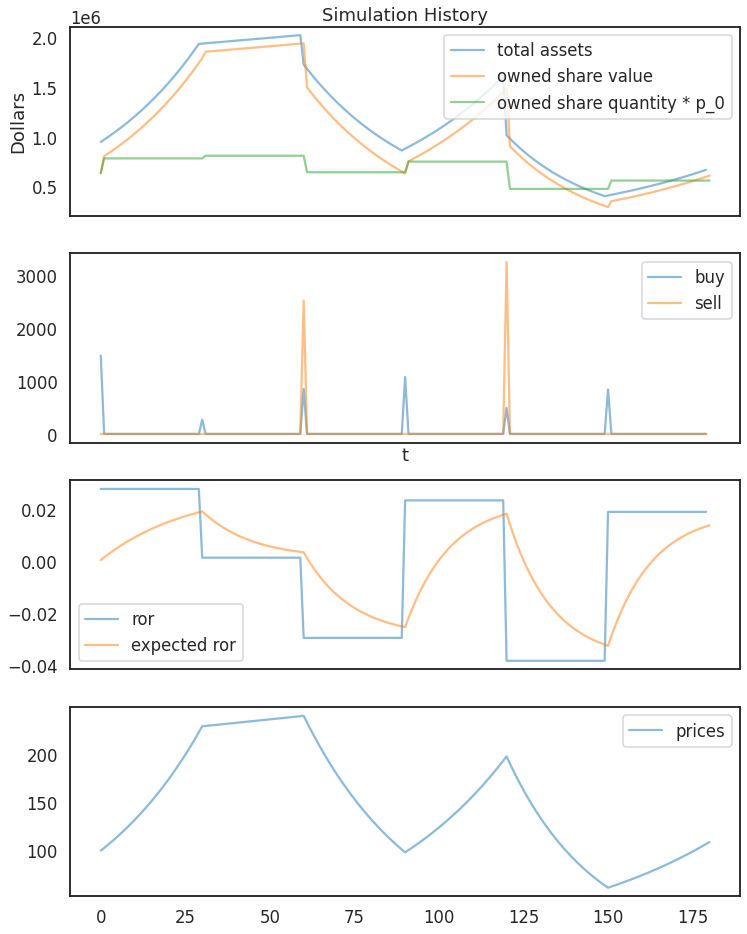

In [18]:
fig, ax = plt.subplots(
    4, 1,
    sharex='col',
    #sharey='col',
    figsize=(12,16),
)

ax[0].plot(history['total_assets'][1:], alpha=0.5, label='total assets')
ax[0].plot([p * o for (p,o) in zip(fm.prices, history['owned_shares'])], alpha=0.5, label='owned share value')
ax[0].plot([100 * o for (p,o) in zip(fm.prices, history['owned_shares'])], alpha=0.5, label='owned share quantity * p_0')
ax[0].legend()

ax[1].plot([bs[0] for bs in broker.buy_sell_history], alpha=0.5, label='buy')
ax[1].plot([bs[1] for bs in broker.buy_sell_history], alpha=0.5, label='sell')
ax[1].legend()

ax[2].plot(fm.ror_list, alpha=0.5, label='ror')
ax[2].plot(fm.expected_ror_list, alpha=0.5, label='expected ror')
ax[2].legend()

ax[3].plot(fm.prices, alpha=0.5, label='prices')
ax[3].legend()
    
ax[0].set_title("Simulation History")
ax[0].set_ylabel("Dollars")
ax[1].set_xlabel("t")
        
plt.show()

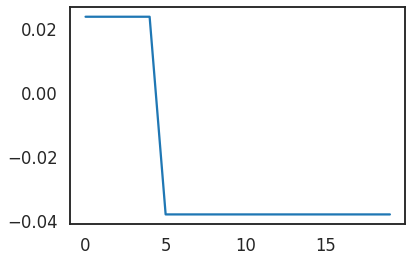

In [19]:
plt.plot(fm.ror_list[115:135])

In [20]:
data = pd.DataFrame.from_dict({
    't' : range(len(fm.prices)),
    'prices' : fm.prices,
    'buy' : [None] + [bs[0] for bs in broker.buy_sell_history],
    'sell' : [None]  + [bs[1] for bs in broker.buy_sell_history],
    'owned' : history['owned_shares'],
    'total_assets' : history['total_assets'],
    'ror' : [None] + fm.ror_list,
    'expected_ror' : fm.expected_ror_list,
    'expected_std' : fm.expected_std_list,
})


data

,t,prices,buy,sell,owned,total_assets,ror,expected_ror,expected_std
0,0,100.000000,NaN,NaN,6359.379704,6.359380e+05,NaN,0.000628,0.011988
1,1,102.799105,1477.0,0.0,7836.800111,9.495314e+05,0.027991,0.001658,0.012822
2,2,105.676560,0.0,0.0,7836.800111,9.720814e+05,0.027991,0.002650,0.013437
3,3,108.634558,0.0,0.0,7836.800111,9.952627e+05,0.027991,0.003604,0.013884
4,4,111.675353,0.0,0.0,7836.800111,1.019093e+06,0.027991,0.004522,0.014200
...,...,...,...,...,...,...,...,...,...
176,176,100.955453,0.0,0.0,5600.466088,6.239657e+05,0.019176,0.012146,0.018849
177,177,102.891409,0.0,0.0,5600.466088,6.348080e+05,0.019176,0.012664,0.018233
178,178,104.864490,0.0,0.0,5600.466088,6.458581e+05,0.019176,0.013144,0.017629
179,179,106.875408,0.0,0.0,5600.466088,6.571202e+05,0.019176,0.013589,0.017038


In [21]:
data.corr()

,t,prices,buy,sell,owned,total_assets,ror,expected_ror,expected_std
t,1.000000,-0.627402,-0.069087,0.008679,-0.783630,-0.737296,-0.204866,-0.365943,0.745444
prices,-0.627402,1.000000,-0.046551,0.114546,0.647230,0.964805,0.013298,0.553476,-0.624497
buy,-0.069087,-0.046551,1.000000,0.394609,0.021446,-0.041398,0.045869,-0.057146,-0.072398
sell,0.008679,0.114546,0.394609,1.000000,-0.104519,0.032829,-0.142557,0.069194,-0.024944
owned,-0.783630,0.647230,0.021446,-0.104519,1.000000,0.810466,0.598365,0.607568,-0.696364
total_assets,-0.737296,0.964805,-0.041398,0.032829,0.810466,1.000000,0.165398,0.562945,-0.734667
ror,-0.204866,0.013298,0.045869,-0.142557,0.598365,0.165398,1.000000,0.676181,-0.137521
expected_ror,-0.365943,0.553476,-0.057146,0.069194,0.607568,0.562945,0.676181,1.000000,-0.318664
expected_std,0.745444,-0.624497,-0.072398,-0.024944,-0.696364,-0.734667,-0.137521,-0.318664,1.000000


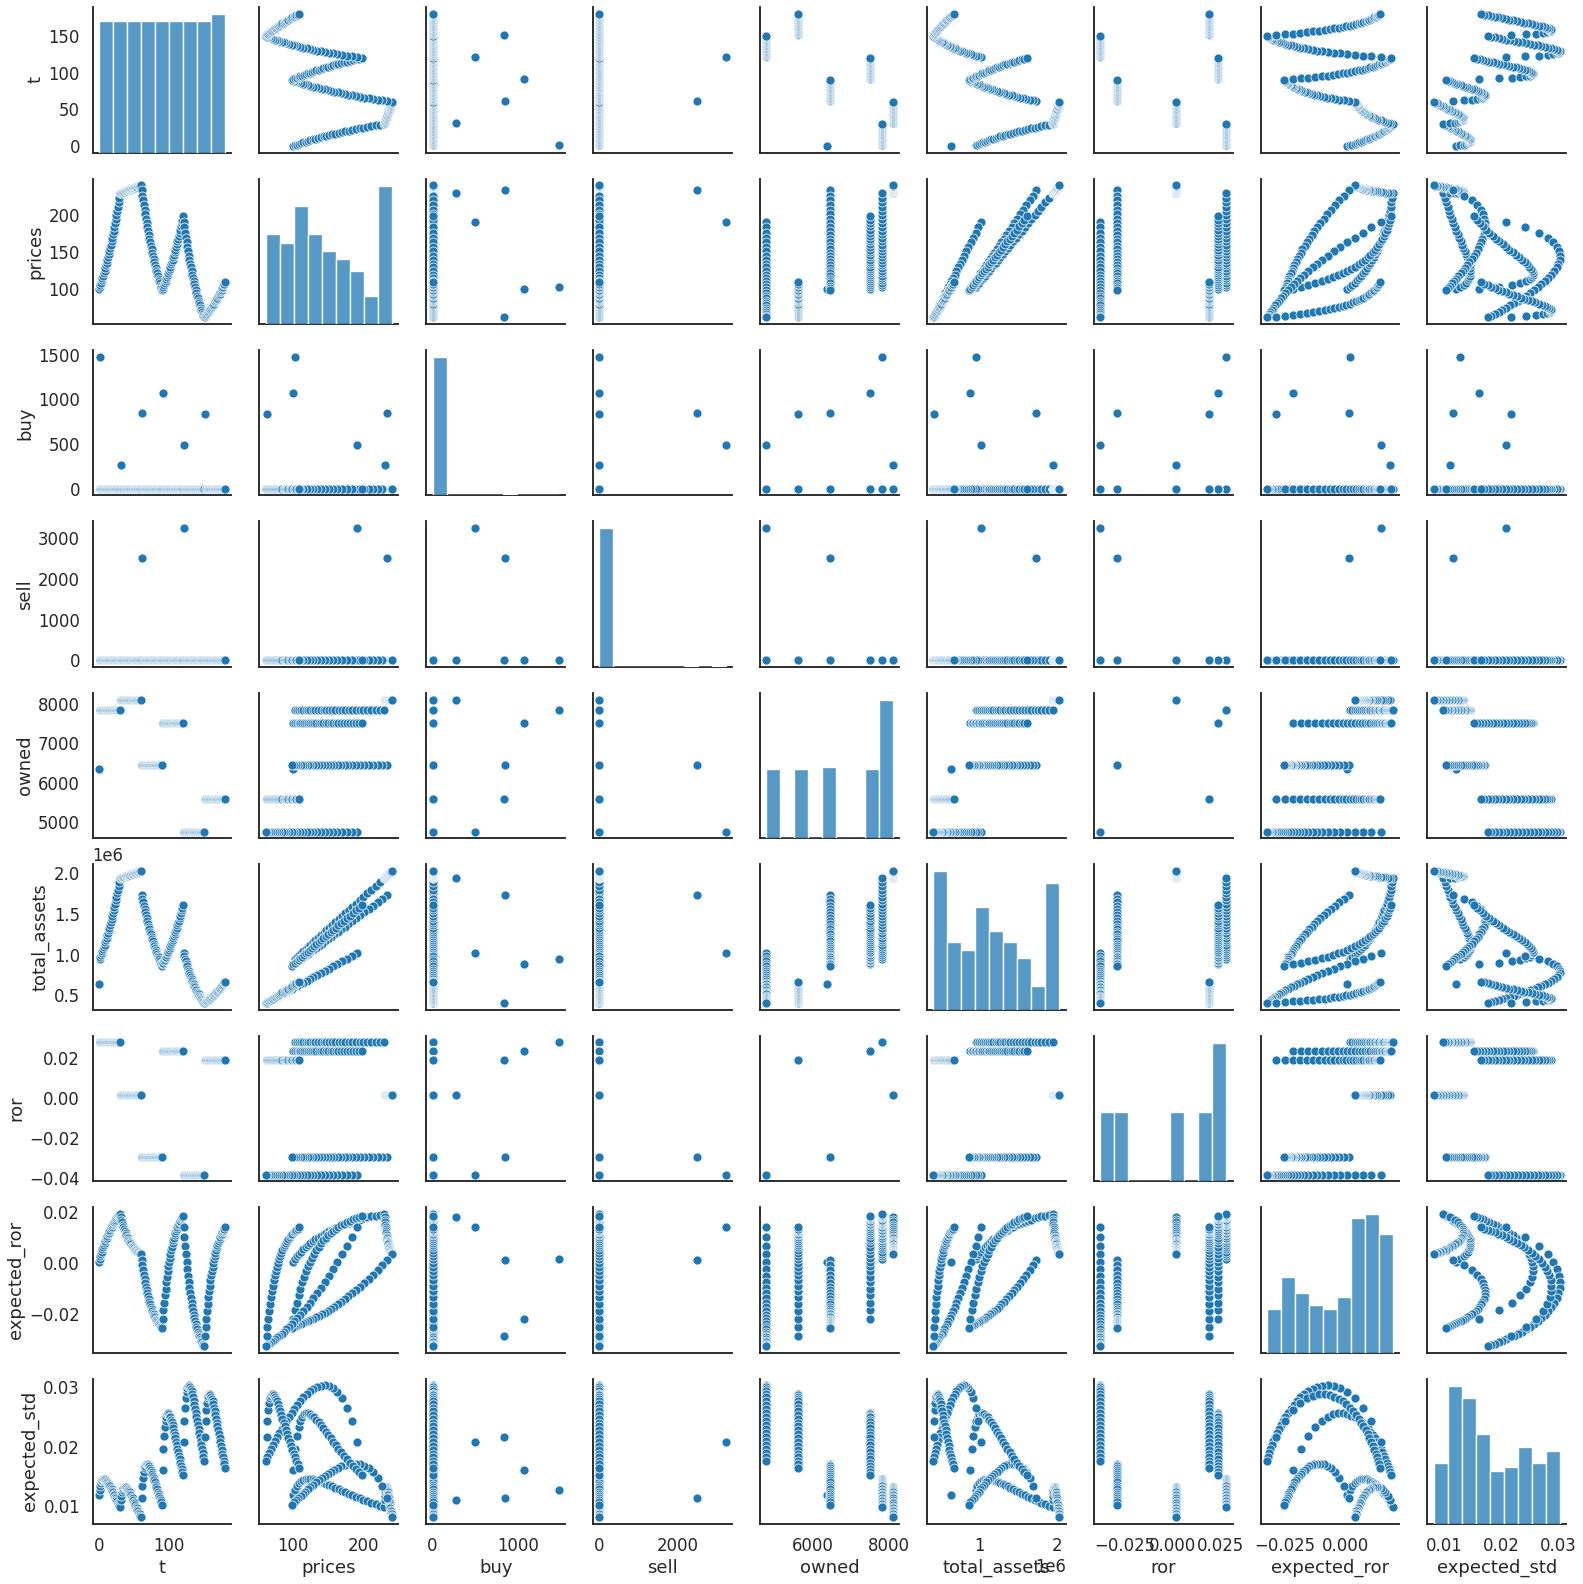

In [22]:
import seaborn as sns

sns.pairplot(data)